In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

from sklearn.decomposition import PCA

from nnwmf.functions.robustpca import RobustPCA

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

In [2]:
data_dir = "../data"
beta_df_filename  = f"{data_dir}/beta_df.pkl"
prec_df_filename  = f"{data_dir}/prec_df.pkl"
trait_df_filename = f"{data_dir}/trait_meta.csv"


'''
Data Frames for beta, precision, standard error and zscore.
'''
beta_df = pd.read_pickle(beta_df_filename)
prec_df = pd.read_pickle(prec_df_filename)
se_df = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan)
zscore_df = beta_df / se_df
zscore_df = zscore_df.replace(np.nan, 0)

trait_df = pd.read_csv(trait_df_filename)
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:

'''
Filter samples using mean of SE and std of beta
'''

mean_se = prec_df.apply(lambda x : 1 / np.sqrt(x)).replace([np.inf, -np.inf], np.nan).mean(axis = 0, skipna = True)
mean_se = pd.DataFrame(mean_se).set_axis(["mean_se"], axis = 1)
beta_std = beta_df.std(axis = 0, skipna = True)
beta_std = pd.DataFrame(beta_std).set_axis(["beta_std"], axis = 1)
error_df = pd.concat([mean_se, beta_std], axis = 1)
select_ids = error_df.query("mean_se <= 0.2 and beta_std <= 0.2").index

X = np.array(zscore_df[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"After filtering, we have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

After filtering, we have 69 samples (phenotypes) and 8403 features (variants)


In [4]:
n, p = Xcent.shape
test_size = 0.33
O = np.ones(n * p)
ntest = int(test_size * n * p)
O[:ntest] = 0
np.random.shuffle(O)
O = O.reshape(n, p)

Xmiss = X * O

In [9]:
train_mask = O
test_mask = 1 - O
Xtrain = X * train_mask
Xtest = X * test_mask

In [13]:
def f_rmse(X, Y, mask = None):
    '''
    RMSE for masked CV
    '''
    Xmask = X if mask is None else X * mask
    return np.sqrt(np.mean(np.square(Xmask - Y)))

In [65]:
lmb_seq = np.logspace(-5, 5, 10)
rpca = dict()
L = dict()
M = dict()
err_train = dict()
err_test = dict()
for i, lmb in enumerate(lmb_seq):
    rpca[i] = RobustPCA(lmb=lmb, max_iter=1000)
    L[i], M[i] = rpca[i].fit(Xmiss)
    err_test[i] = f_rmse(X, M[i], mask = test_mask)
    err_train[i] = f_rmse(X, L[i], mask = train_mask)

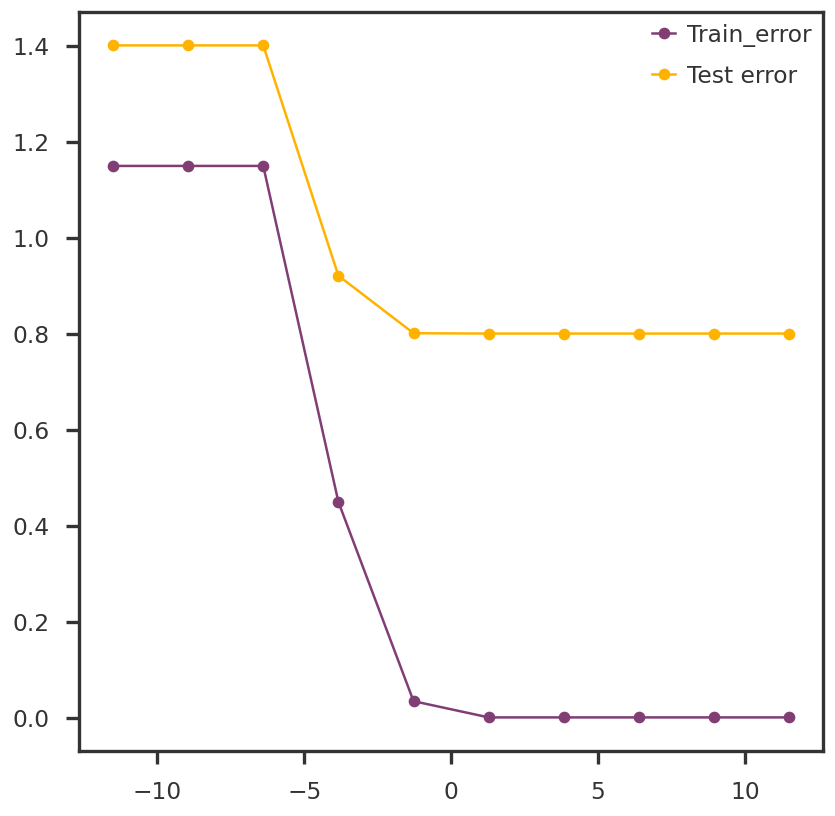

In [66]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.log(lmb_seq), err_train.values(), 'o-', label = "Train_error")
ax1.plot(np.log(lmb_seq), err_test.values(), 'o-', label = "Test error")
ax1.legend()
plt.show()

In [67]:
min(err_test.items(), key=lambda x: x[1]) 

(5, 0.8008069891518402)

In [71]:
lmb_seq[1]

0.0001291549665014884